Import Libraries for Visualization

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
#from sklearn.preprocessing import label_binarize

Load results

In [2]:
def load_results(results_path):
    with open(results_path, 'r') as file:
        data = json.load(file)
    results = {}
    for feature_set, models in data.items():
        results[feature_set] = models
    return results

results_path = '../results/model_results.json'
model_results = load_results(results_path)


def load_pred_results(results_path):
    with open(results_path, 'r') as file:
        data = json.load(file)
    pred_results = {}
    for feature_set, models in data.items():
        pred_results[feature_set] = models
    return pred_results

results_path = '../results/pred_results.json'
pred_results = load_pred_results(results_path)

Save results as Pandas Dataframe and csv

In [3]:
def metrics(results):
    
    metrics = []
    for feature_set, models in results.items():
        for model, data in models.items():
            metrics.append({
                'Feature_Set': feature_set,
                'Model': model,
                'CV Accuracy': data['cv_accuracy'],
                'Accuracy': data['test_accuracy'],
                'Precision Score': data['test_precision'],
                'Recall Score': data['test_recall'],
                'F1 Score': data['test_f1'],
                'Cohen Kappa Score': data['cohen_kappa'],
            })

    df = pd.DataFrame(metrics)
    return df
    
metrics_df = metrics(model_results)

#Save to CSV
#metrics_df.to_csv('../results/model_results.csv', index=False)
metrics_df

,Feature_Set,Model,CV Accuracy,Accuracy,Precision Score,Recall Score,F1 Score,Cohen Kappa Score
0,F_fanger,ET,0.736421,0.767184,0.768226,0.775641,0.770656,0.648759
1,F_fanger,SVC,0.702162,0.676275,0.676017,0.693547,0.676409,0.514979
2,F_all,ET,0.833482,0.802661,0.803311,0.809251,0.805831,0.702061
3,F_all,SVC,0.823006,0.809313,0.808321,0.817685,0.811491,0.712784
4,F_accessible,ET,0.828725,0.807095,0.807966,0.813843,0.810411,0.708745
5,F_accessible,SVC,0.811596,0.818182,0.817256,0.827654,0.820150,0.726499


Metrics Plot for Feature Sets

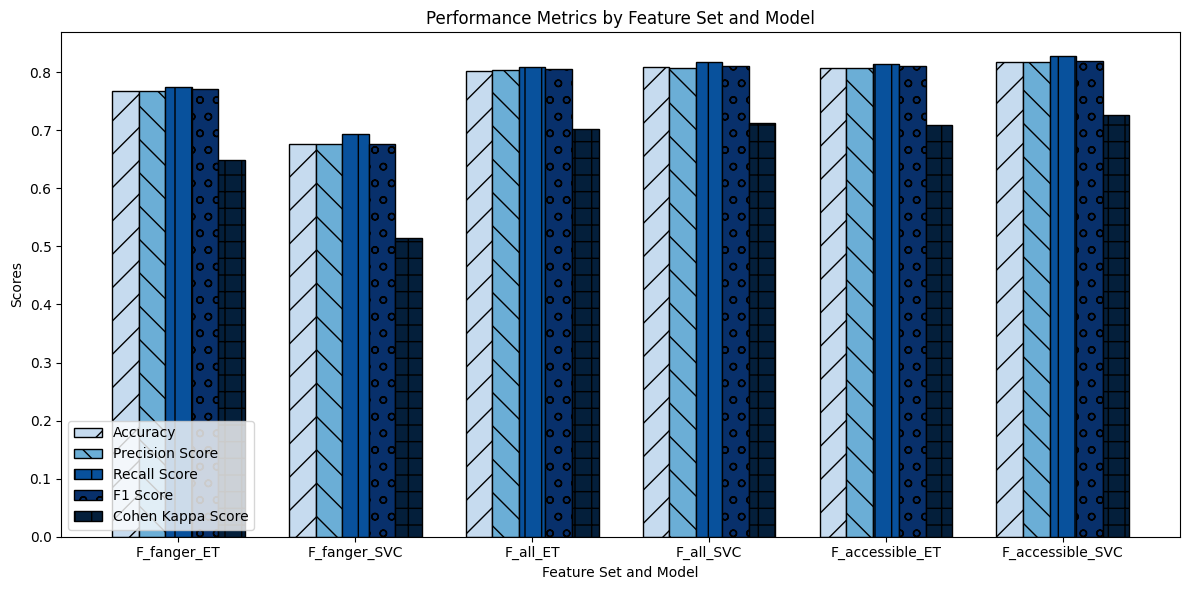

In [16]:
def plot_abs_metrics():
    metrics_to_plot = ['Accuracy', 'Precision Score', 'Recall Score', 'F1 Score', 'Cohen Kappa Score']
    df = metrics_df.copy()
    df['Feature_Model'] = df['Feature_Set'] + '_' + df['Model']

    barWidth = 0.15
    r = np.arange(len(df))
    positions = [r + (i * barWidth) for i in range(len(metrics_to_plot))]

    colors = ['#c6dbef', '#6baed6', '#08519c', '#08306b', '#041f3b']
    hatches = ['/', '\\', '|', 'o', '+']

    plt.figure(figsize=(12, 6))
    for i, (metric, color, hatch) in enumerate(zip(metrics_to_plot, colors, hatches)):
        plt.bar(positions[i], df[metric], width=barWidth, color=color, edgecolor='black', 
                hatch=hatch, label=metric)

    plt.xlabel('Feature Set and Model')
    plt.ylabel('Scores')
    plt.title('Performance Metrics by Feature Set and Model')
    plt.xticks([r + (len(metrics_to_plot) - 1) * barWidth / 2 for r in range(len(df))], df['Feature_Model'])
    plt.legend(loc='lower left') 
    plt.tight_layout()
    plt.savefig('../results_plots/graph_abs_plot.png', bbox_inches='tight')
    plt.show()

plot_abs_metrics()


Plot of Test Accuracy, Cohen Kappa and F1-Score for Feature Sets

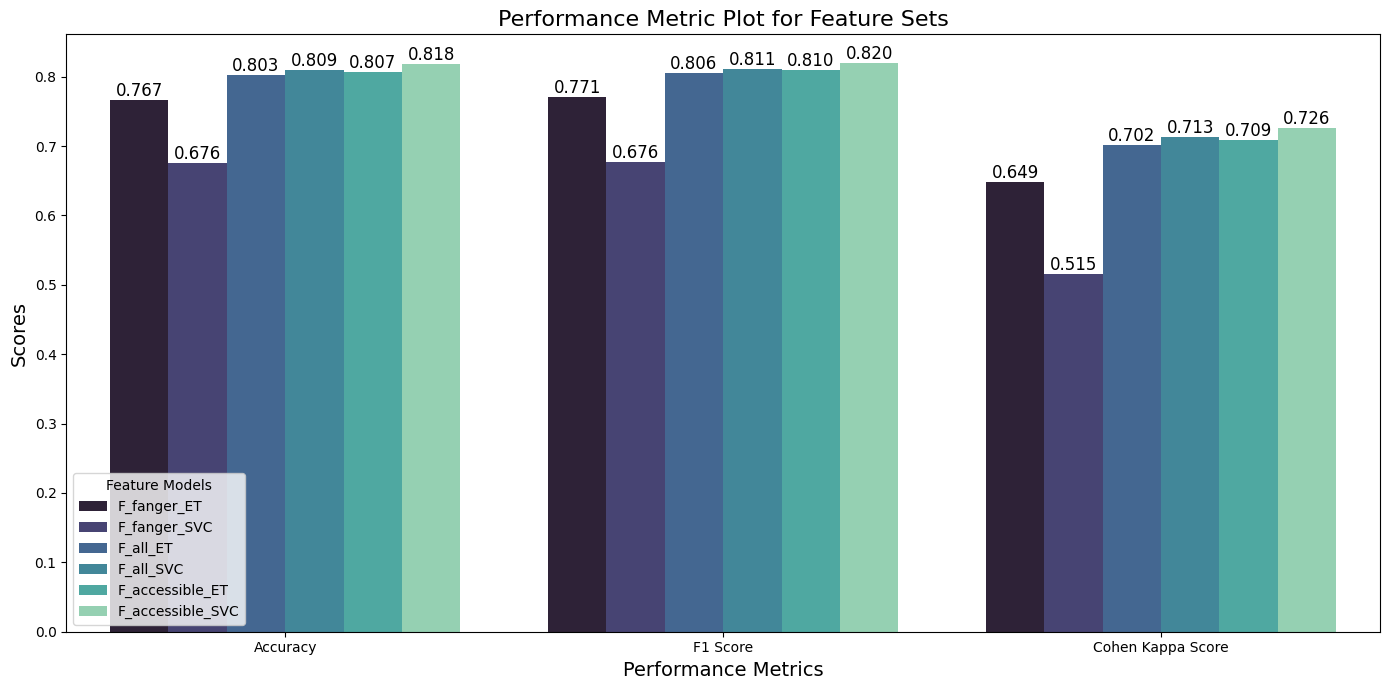

In [ ]:
def plot_metrics_groupedbar(df):
    df['Feature_Model'] = df['Feature_Set'] + '_' + df['Model']
    df = df.drop(['Feature_Set', 'Model'], axis=1)

    metrics_list = ['Accuracy', 'F1 Score', 'Cohen Kappa Score']
    df = df[['Feature_Model'] + metrics_list]

    df_long = df.melt(id_vars='Feature_Model', var_name='Metric', value_name='Score')

    plt.figure(figsize=(14, 7))
    ax = sns.barplot(data=df_long, x='Metric', y='Score', hue='Feature_Model', palette='mako')

    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', label_type='edge', fontsize=12)

    plt.title('Performance Metric Plot for Feature Sets', fontsize=16)
    plt.xlabel('Performance Metrics', fontsize=14)
    plt.ylabel('Scores', fontsize=14)
    plt.legend(title='Feature Models', fontsize=10)
    plt.xticks()
    plt.tight_layout()
    plt.savefig('../results_plots/metric_plot.png', bbox_inches='tight')
    plt.show()

plot_metrics_groupedbar(metrics_df)


Plot classification report heatmap

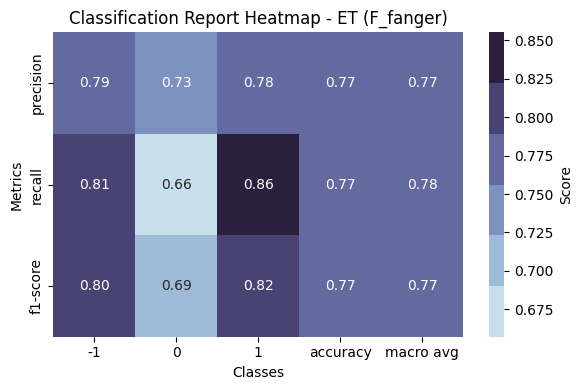

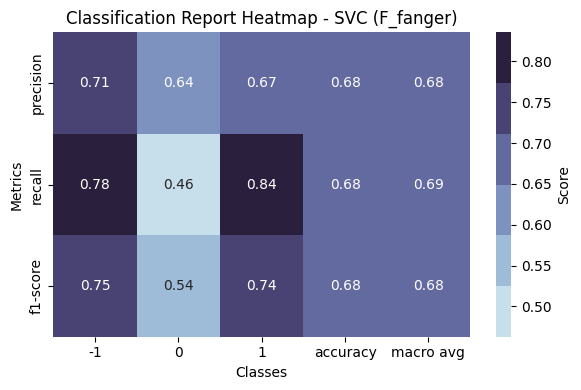

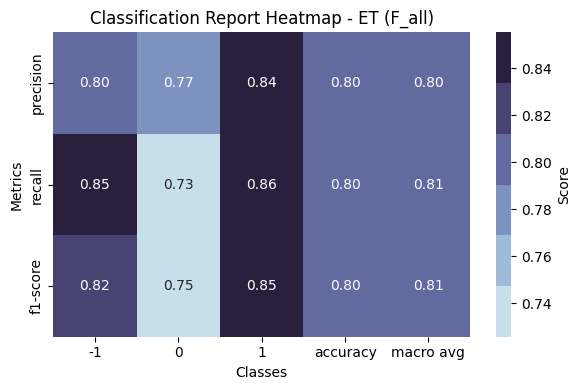

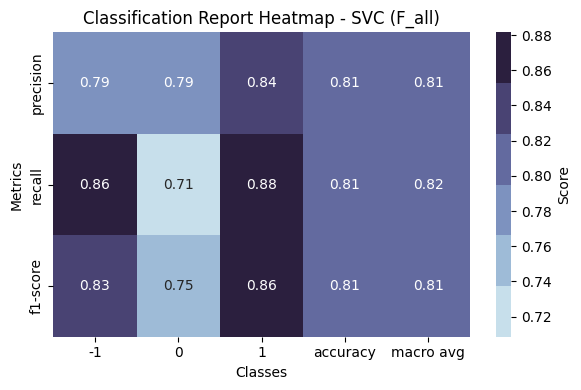

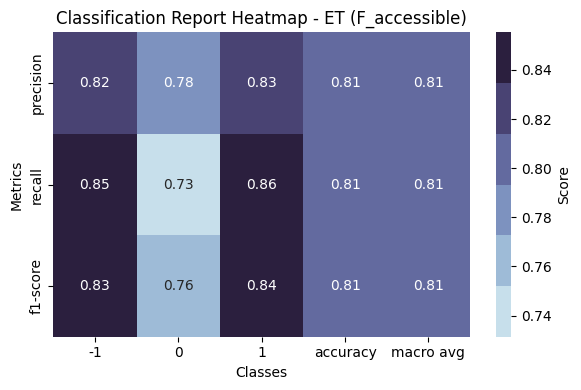

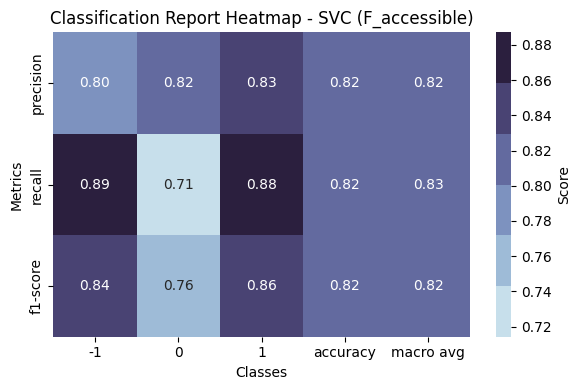

In [95]:
def plot_classification_report(results):
    for feature_set, models in results.items():
        for model, data in models.items():
            y_test = data['y_test']
            y_pred = data['y_pred']

            report = classification_report(y_test, y_pred, output_dict=True)
            report_df = pd.DataFrame(report).transpose().drop(columns=["support"])

            plt.figure(figsize=(6, 4))
            sns.heatmap(
                report_df.iloc[:-1, :].T, annot=True, fmt=".2f",
                cmap=sns.color_palette('ch:s=.25,rot=-.25'), cbar_kws={'label': 'Score'}
            )
            plt.title(f"Classification Report Heatmap - {model} ({feature_set})")
            plt.ylabel('Metrics')
            plt.xlabel('Classes')
            plt.tight_layout()
            plt.savefig(f'../results_plots/cm_heatmap_{model}_{feature_set}.png', bbox_inches='tight')
            plt.show()

plot_classification_report(pred_results)

Plot confusion matrix

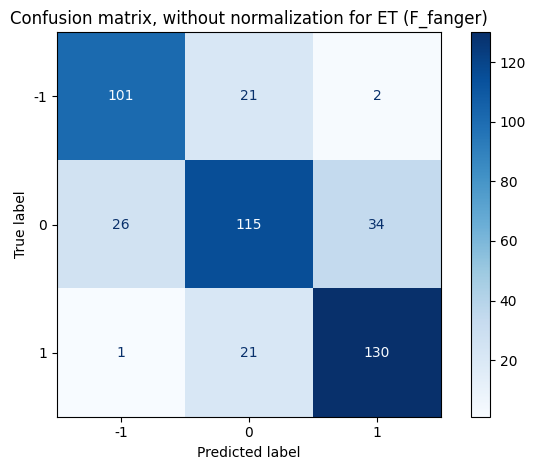

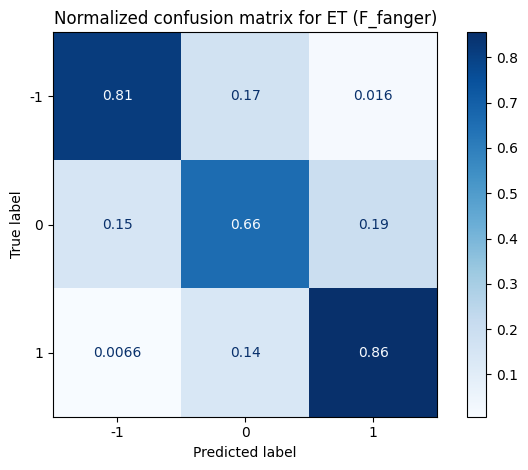

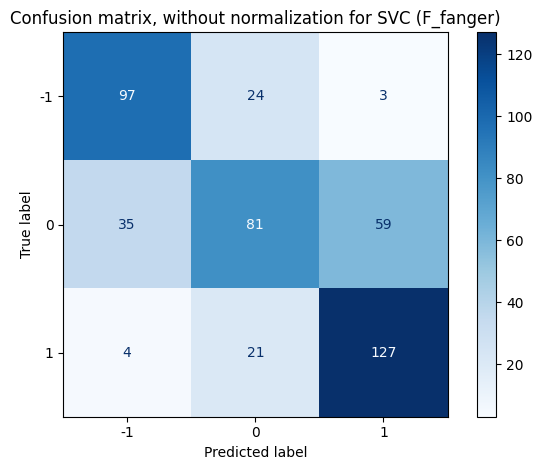

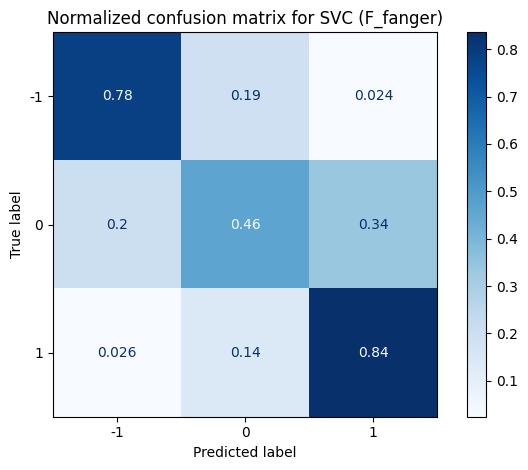

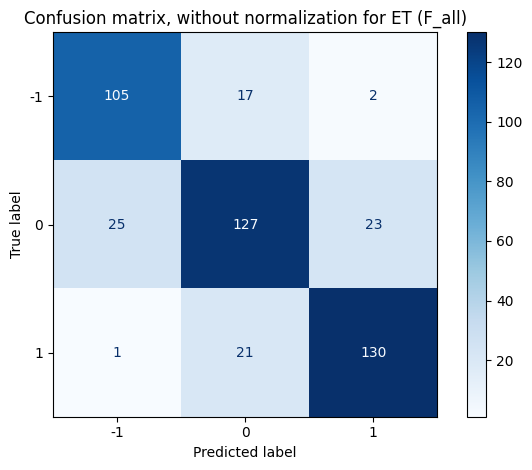

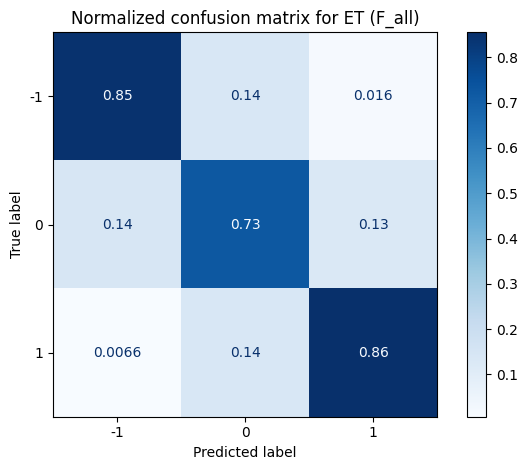

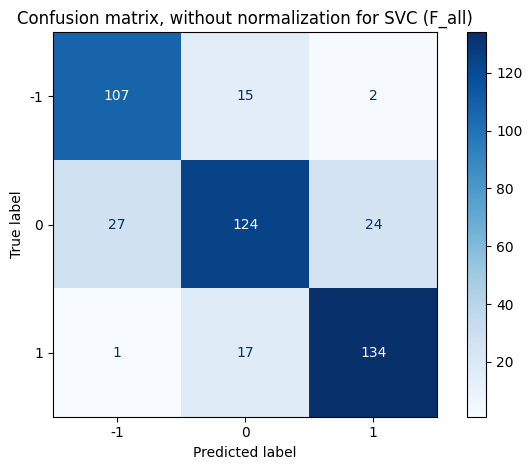

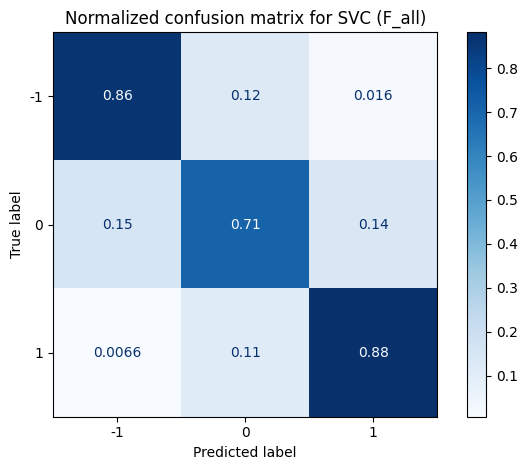

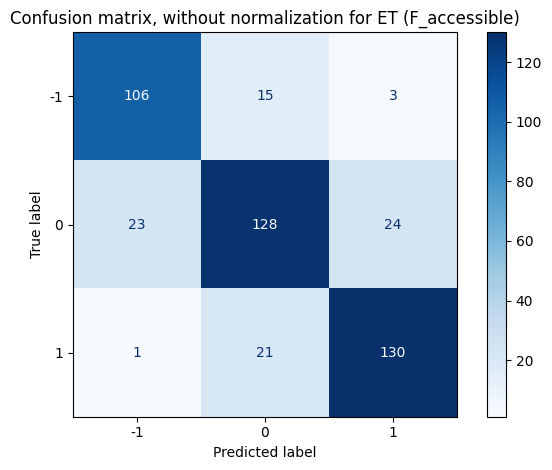

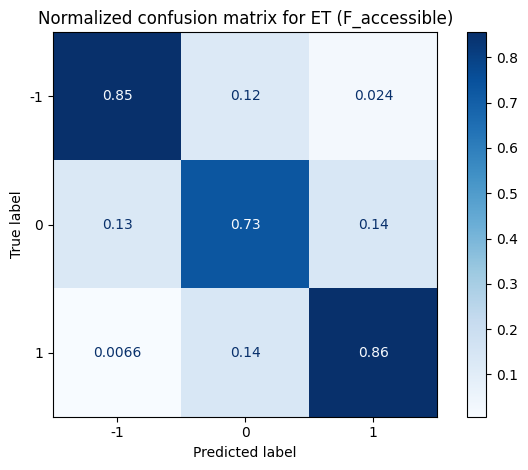

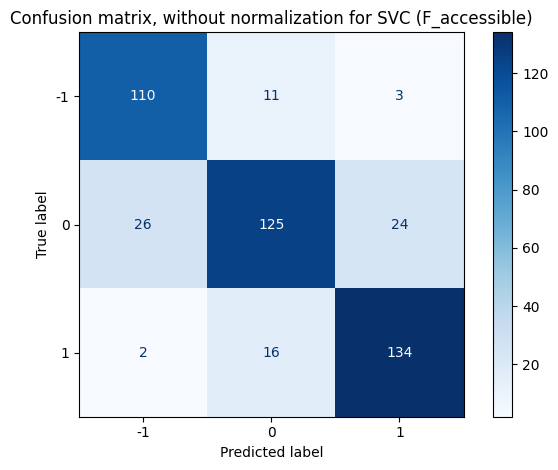

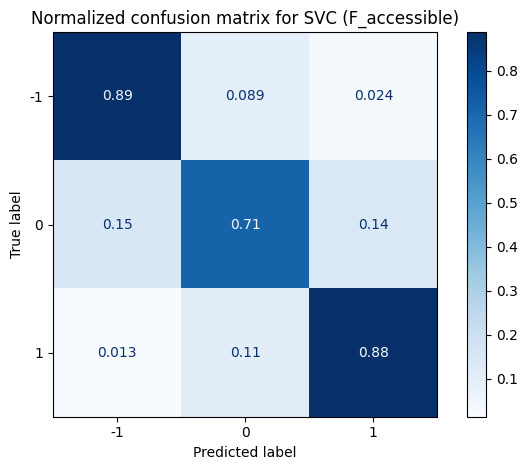

In [92]:
def plot_confusion_matrix(results):
    for feature_set, models in results.items():
        for model, data in models.items():
            y_test = data['y_test']
            y_pred = data['y_pred']
            class_labels = [-1, 0, 1]
            titles_options = [
                ("Confusion matrix, without normalization", None),
                ("Normalized confusion matrix", "true"),
            ]
            for title, normalize in titles_options:
                disp = ConfusionMatrixDisplay.from_predictions(
                    y_test,
                    y_pred,
                    display_labels=class_labels,
                    cmap='Blues',
                    normalize=normalize)
                plt.title(f'{title} for {model} ({feature_set})')
                plt.tight_layout()
                name_tag = "normalized" if normalize == "true" else "unnormalized"
                plt.savefig(f'../results_plots/cm_{model}_{feature_set}_{name_tag}.png', bbox_inches='tight')
                plt.show()

plot_confusion_matrix(pred_results)


Plot ROC curve

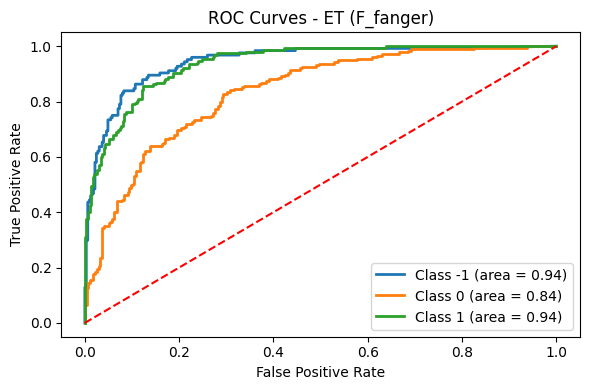

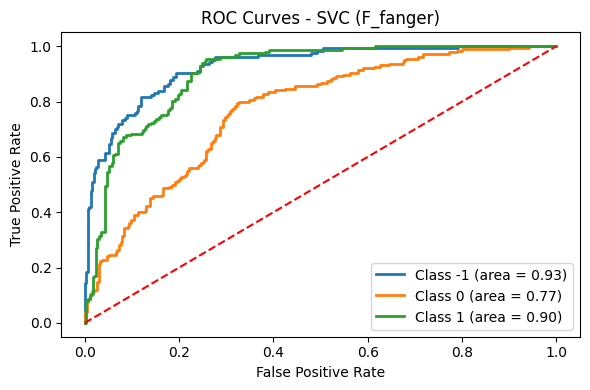

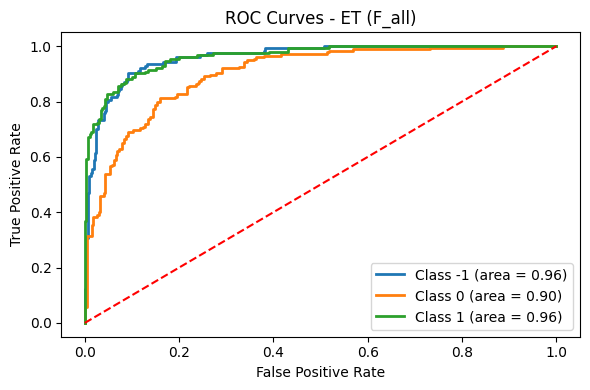

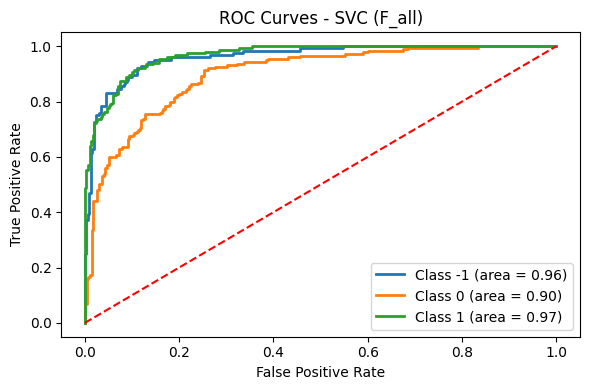

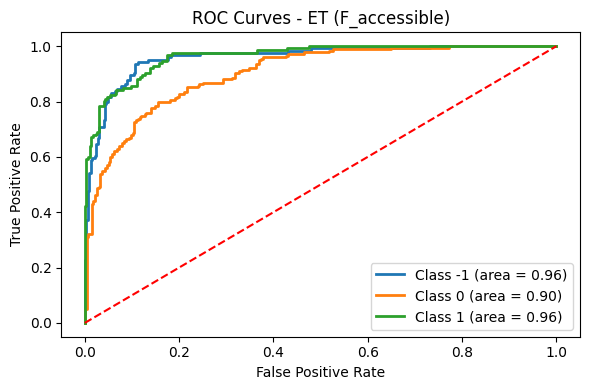

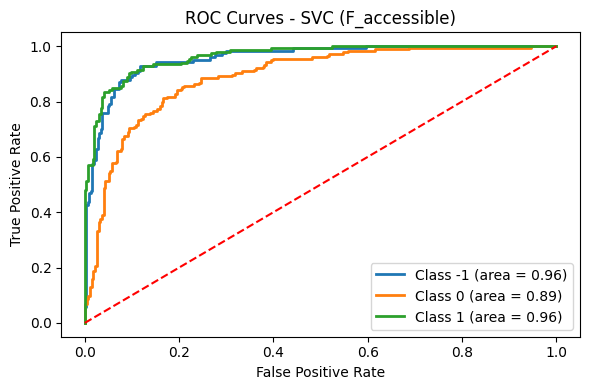

In [96]:
def plot_roc_curve(results, class_labels):
    for feature_set, models in results.items():
        for model, data in models.items():
            y_test = data['y_test']
            y_proba = np.array(data['y_proba']) 

            #map original classes to non-negative integers
            class_mapping = {label: idx for idx, label in enumerate(sorted(np.unique(y_test)))}
            y_test_mapped = np.array([class_mapping[label] for label in y_test])

            #binarize output for multi-class ROC curve
            y_test_bin = label_binarize(y_test_mapped, classes=range(len(class_labels)))

            plt.figure(figsize=(6, 4))
            
            for class_idx in range(y_proba.shape[1]):
                    fpr, tpr, _ = roc_curve(y_test_bin[:, class_idx], [probs[class_idx] for probs in y_proba])
                    roc_auc = auc(fpr, tpr)
                    plt.plot(fpr, tpr, lw=2, label=f'{class_labels[class_idx]} (area = {roc_auc:.2f})')
                    
            plt.plot([0, 1], [0, 1], color='red', linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f"ROC Curves - {model} ({feature_set})")
            plt.legend(loc='lower right')
            plt.tight_layout()
            plt.savefig(f'../results_plots/ROC_curve_{model}_{feature_set}.png', bbox_inches='tight')
            plt.show()


class_labels = ['Class -1', 'Class 0', 'Class 1']

plot_roc_curve(pred_results, class_labels)



Precision-Recall Curve

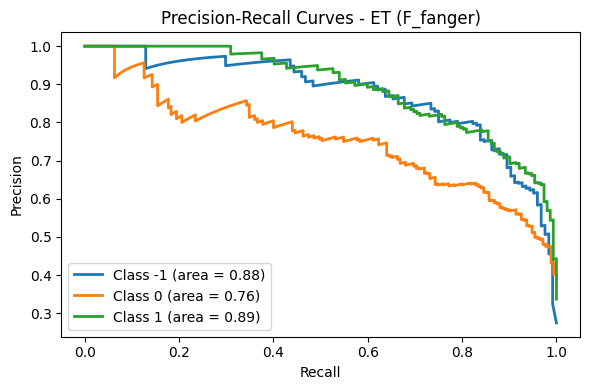

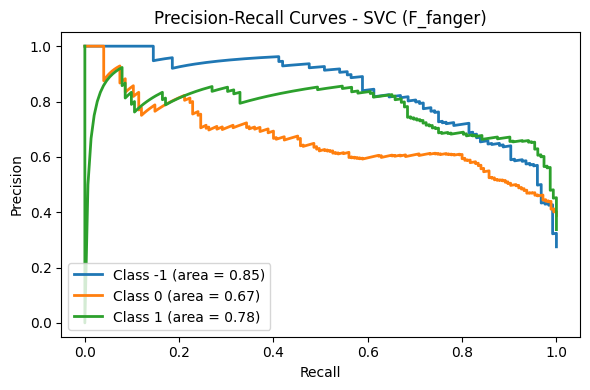

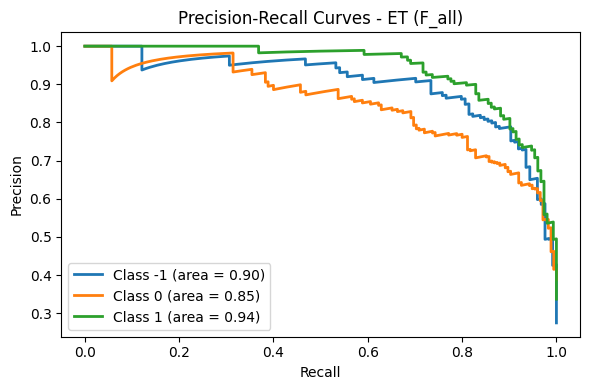

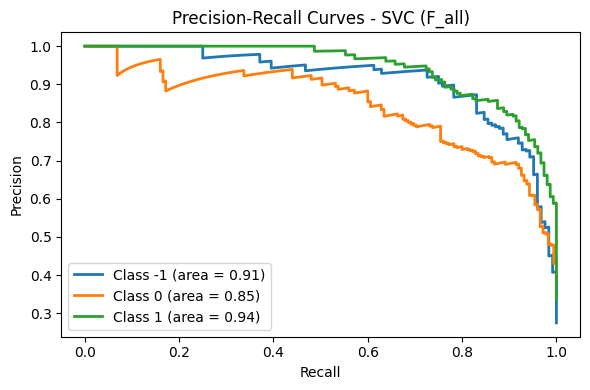

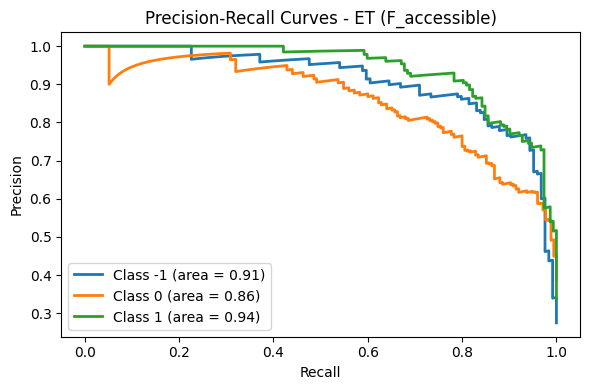

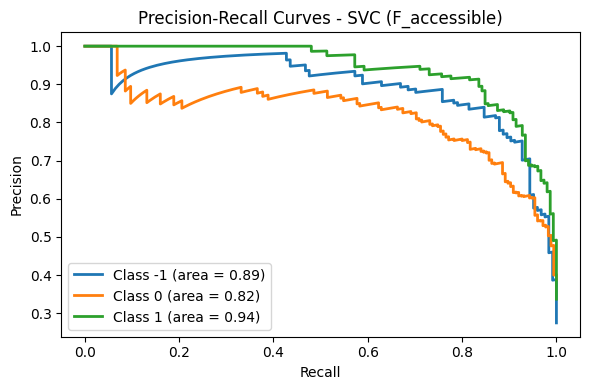

In [97]:
def plot_precision_recall(results, class_labels):
    for feature_set, models in results.items():
        for model, data in models.items():
            y_test = data['y_test']
            y_proba = np.array(data['y_proba'])

            y_test_bin = label_binarize(y_test, classes=[-1, 0, 1])

            plt.figure(figsize=(6, 4))

            for class_idx in range(y_proba.shape[1]):
                y_pred_proba_class = [probs[class_idx] for probs in y_proba]
                precision, recall, _ = precision_recall_curve(y_test_bin[:, class_idx], y_pred_proba_class)
                average_precision = average_precision_score(y_test_bin[:, class_idx], y_pred_proba_class)

                plt.plot(recall, precision, lw=2, label=f'{class_labels[class_idx]} (area = {average_precision:.2f})')

            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f"Precision-Recall Curves - {model} ({feature_set})")
            plt.legend(loc='lower left')
            plt.tight_layout()
            plt.savefig(f'../results_plots/p_r_curves_{model}_{feature_set}.png', bbox_inches='tight')
            plt.show()

class_labels = ['Class -1', 'Class 0', 'Class 1']

plot_precision_recall(pred_results, class_labels)



Density Distribution of predicted vs actual in the test data

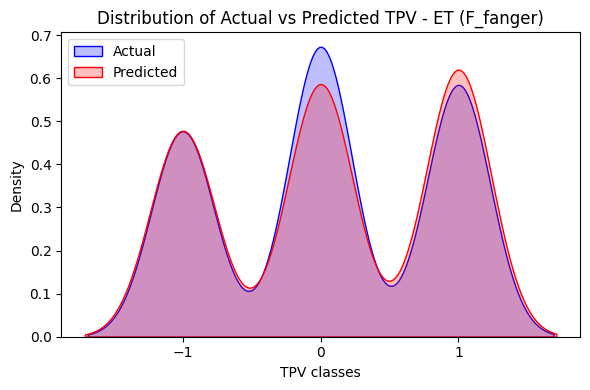

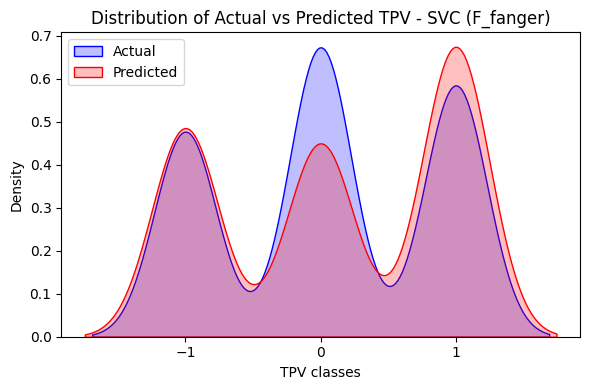

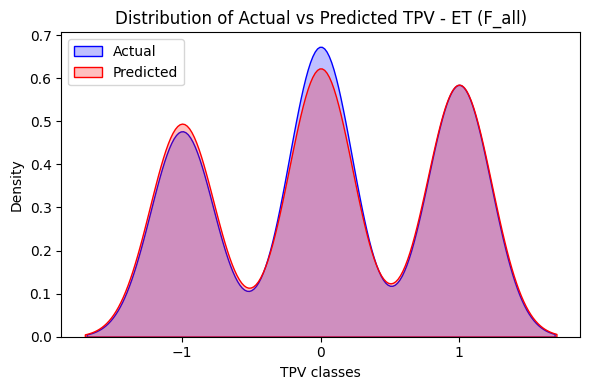

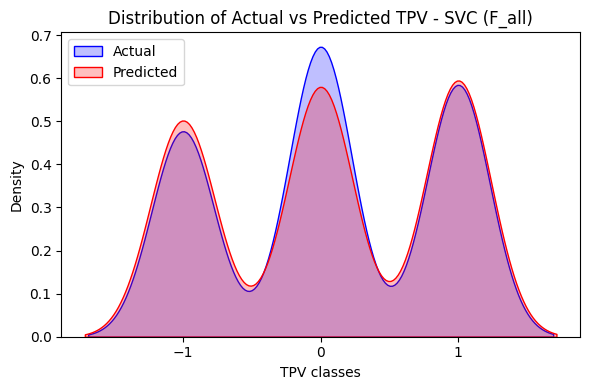

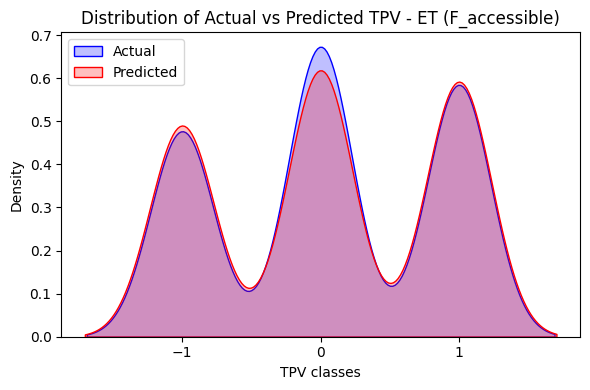

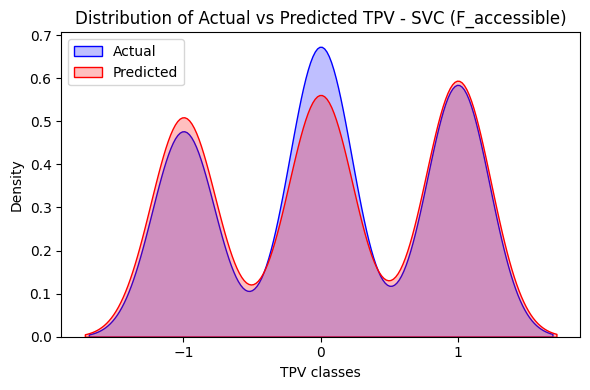

In [91]:
def plot_distributions(results):
    for feature_set, models in results.items():
        for model, data in models.items():
            y_test = data['y_test']
            y_pred = data['y_pred']

            if hasattr(y_test, 'shape') and len(y_test.shape) > 1:
                y_test = y_test.flatten()
            if hasattr(y_pred, 'shape') and len(y_pred.shape) > 1:
                y_pred = y_pred.flatten()

            plt.figure(figsize=(6, 4))
            sns.kdeplot(y_test, color='blue', label='Actual', fill=True)
            sns.kdeplot(y_pred, color='red', label='Predicted', fill=True)
            plt.title(f"Distribution of Actual vs Predicted TPV - {model} ({feature_set})")
            plt.xlabel('TPV classes')
            plt.ylabel('Density')
            plt.xticks([-1, 0, 1])
            plt.legend()
            plt.tight_layout()
            plt.savefig(f'../results_plots/density_plot_{model}_{feature_set}.png', bbox_inches='tight')
            plt.show()

plot_distributions(pred_results)
